# Deep Learning Toolkit for Splunk - Correlation Matrix and Pairplot Notebook

This notebook contains an example workflow how to work on custom containerized code that seamlessly interfaces with the Deep Learning Toolkit for Splunk.

Note: By default every time you save this notebook the cells are exported into a python module which is then invoked by Splunk MLTK commands like <code> | fit ... | apply ... | summary </code>. Please read the Model Development Guide in the Deep Learning Toolkit app for more information.

## Stage 0 - import libraries
At stage 0 we define all imports necessary to run our subsequent code depending on various libraries.

In [1]:
# this definition exposes all python module imports that should be available in all subsequent commands
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# ...
# global constants
MODEL_DIRECTORY = "/srv/app/model/data/"

In [2]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print("numpy version: " + np.__version__)
print("pandas version: " + pd.__version__)

numpy version: 1.26.4
pandas version: 2.2.0


## Stage 1 - get a data sample from Splunk
In Splunk run a search to pipe a dataset into your notebook environment. Note: mode=stage is used in the | fit command to do this.

| inputlookup diabetes.csv</br>
| fit MLTKContainer algo=correlationmatrix plot="matrix,pairplot" response from BMI age blood_pressure diabetes_pedigree glucose_concentration number_pregnant serum_insulin skin_thickness into app:diabetes_correlation

After you run this search your data set sample is available as a csv inside the container to develop your model. The name is taken from the into keyword ("barebone_model" in the example above) or set to "default" if no into keyword is present. This step is intended to work with a subset of your data to create your custom model.

In [3]:
# this cell is not executed from MLTK and should only be used for staging data into the notebook environment
def stage(name):
    with open("data/"+name+".csv", 'r') as f:
        df = pd.read_csv(f)
    with open("data/"+name+".json", 'r') as f:
        param = json.load(f)
    return df, param

In [4]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
df, param = stage("diabetes_correlation")
print(df.describe())
print(param)

       number_pregnant  glucose_concentration  blood_pressure  skin_thickness  \
count       768.000000             768.000000      768.000000      768.000000   
mean          3.845052             120.894531       69.105469       20.536458   
std           3.369578              31.972618       19.355807       15.952218   
min           0.000000               0.000000        0.000000        0.000000   
25%           1.000000              99.000000       62.000000        0.000000   
50%           3.000000             117.000000       72.000000       23.000000   
75%           6.000000             140.250000       80.000000       32.000000   
max          17.000000             199.000000      122.000000       99.000000   

       serum_insulin         BMI  diabetes_pedigree         age    response  
count     768.000000  768.000000         768.000000  768.000000  768.000000  
mean       79.799479   31.992578           0.471876   33.240885    0.348958  
std       115.244002    7.884160    

## Stage 2 - create and initialize a model

In [5]:
# initialize your model
# available inputs: data and parameters
# returns the model object which will be used as a reference to call fit, apply and summary subsequently
def init(df,param):
    model = {}
    return model

In [6]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
model = init(df,param)
print(model)

{}


## Stage 3 - fit the model

In [7]:
# train your model
# returns a fit info json object and may modify the model object
def fit(model,df,param):
    # model.fit()
    info = {"message": "no fit needed"}
    return info

In [8]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
print(fit(model,df,param))

{'message': 'no fit needed'}


## Stage 4 - apply the model

In [18]:
# apply your model
# returns the calculated results
def plot_to_base64(plot):
    import base64
    import io 
    pic_IObytes = io.BytesIO()
    if hasattr(plot,'fig'):
        plot.fig.savefig(pic_IObytes, format='png')
    elif hasattr(plot,'figure'):
        plot.figure.savefig(pic_IObytes, format='png')
    pic_IObytes.seek(0)
    pic_hash = base64.b64encode(pic_IObytes.read())
    return pic_hash


def plot_pairplot_as_base64(df,param):
    hue=None
    if 'options' in param:
        if 'target_variable' in param['options']:
            hue=str(param['options']['target_variable'][0])
    plot = sns.pairplot(df,hue=hue, palette="husl")
    return str(plot_to_base64(plot))


def plot_correlationmatrix_as_base64(corr):
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(15, 15))
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=np.bool_))
    print(mask)
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    #plot = sns.heatmap(corr, mask=mask, cmap="Spectral", vmax=1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plot = sns.heatmap(corr, cmap="Spectral", vmax=1.0, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
    #plot.figure.savefig("plot.png", format='png')
    return str(plot_to_base64(plot))

def apply(model,df,param):
    # param['options']['model_name']    
    dfeatures = df[param['feature_variables']]
    result = dfeatures.corr() #.reset_index()
    if 'plot' in param['options']['params']:
        plots = param['options']['params']['plot'].lstrip("\"").rstrip("\"").lower().split(',')
        for plot in plots:
            if plot=='matrix':
                model["plot_matrix"] = plot_correlationmatrix_as_base64(result)
            elif plot=='pairplot':
                model["plot_pairplot"] = plot_pairplot_as_base64(df,param)
            else:
                continue

    return result


[[ True  True  True  True  True  True  True  True]
 [False  True  True  True  True  True  True  True]
 [False False  True  True  True  True  True  True]
 [False False False  True  True  True  True  True]
 [False False False False  True  True  True  True]
 [False False False False False  True  True  True]
 [False False False False False False  True  True]
 [False False False False False False False  True]]


,BMI,age,blood_pressure,diabetes_pedigree,glucose_concentration,number_pregnant,serum_insulin,skin_thickness
BMI,1.000000,0.036242,0.281805,0.140647,0.221071,0.017683,0.197859,0.392573
age,0.036242,1.000000,0.239528,0.033561,0.263514,0.544341,-0.042163,-0.113970
blood_pressure,0.281805,0.239528,1.000000,0.041265,0.152590,0.141282,0.088933,0.207371
diabetes_pedigree,0.140647,0.033561,0.041265,1.000000,0.137337,-0.033523,0.185071,0.183928
glucose_concentration,0.221071,0.263514,0.152590,0.137337,1.000000,0.129459,0.331357,0.057328
number_pregnant,0.017683,0.544341,0.141282,-0.033523,0.129459,1.000000,-0.073535,-0.081672
serum_insulin,0.197859,-0.042163,0.088933,0.185071,0.331357,-0.073535,1.000000,0.436783
skin_thickness,0.392573,-0.113970,0.207371,0.183928,0.057328,-0.081672,0.436783,1.000000


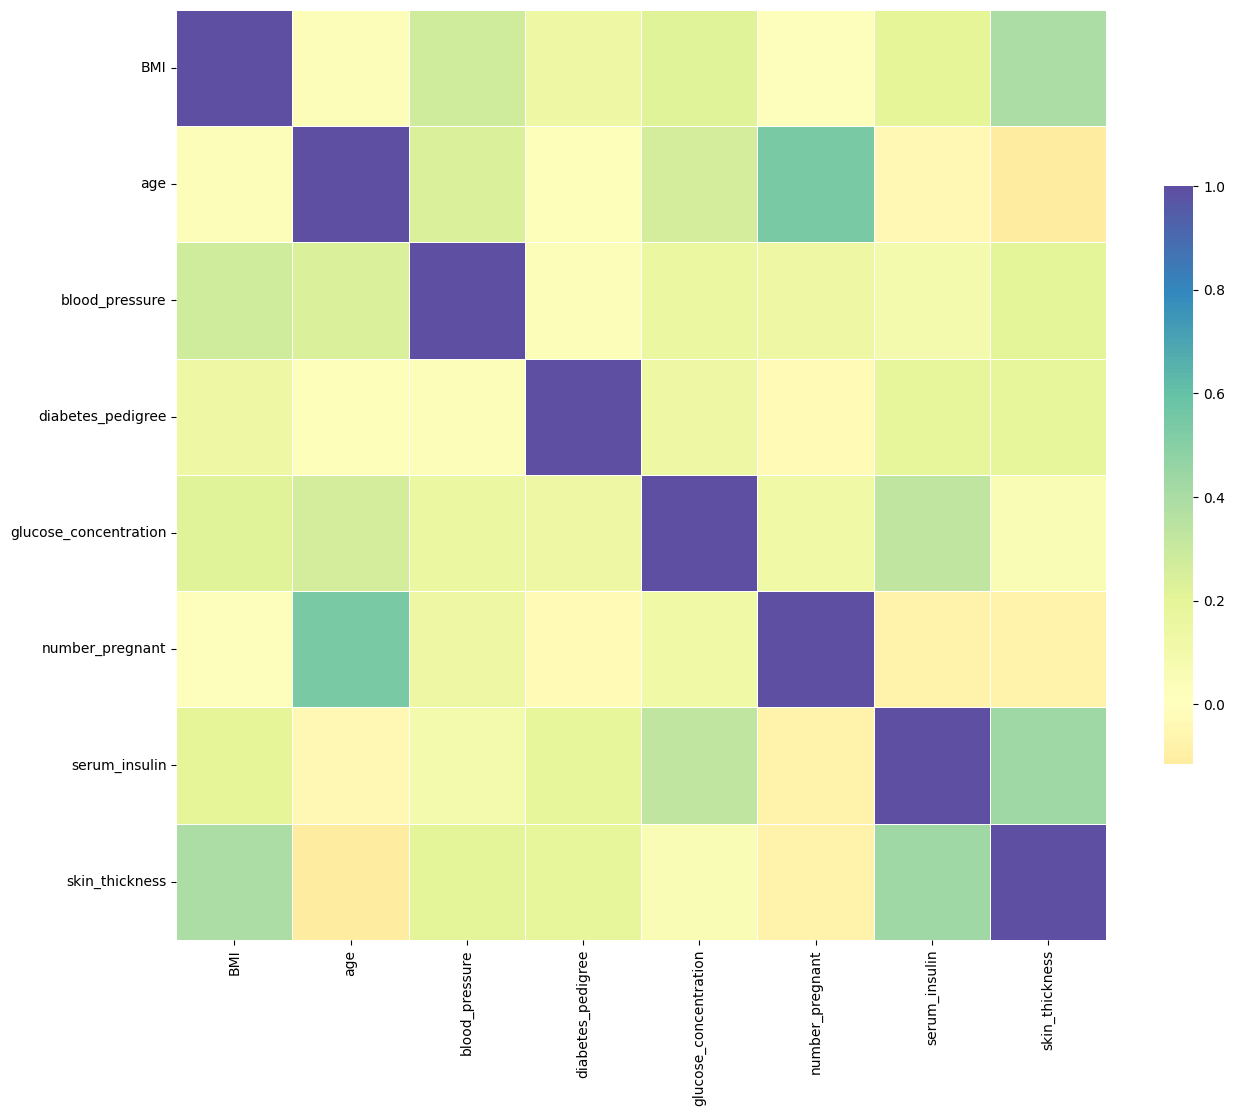

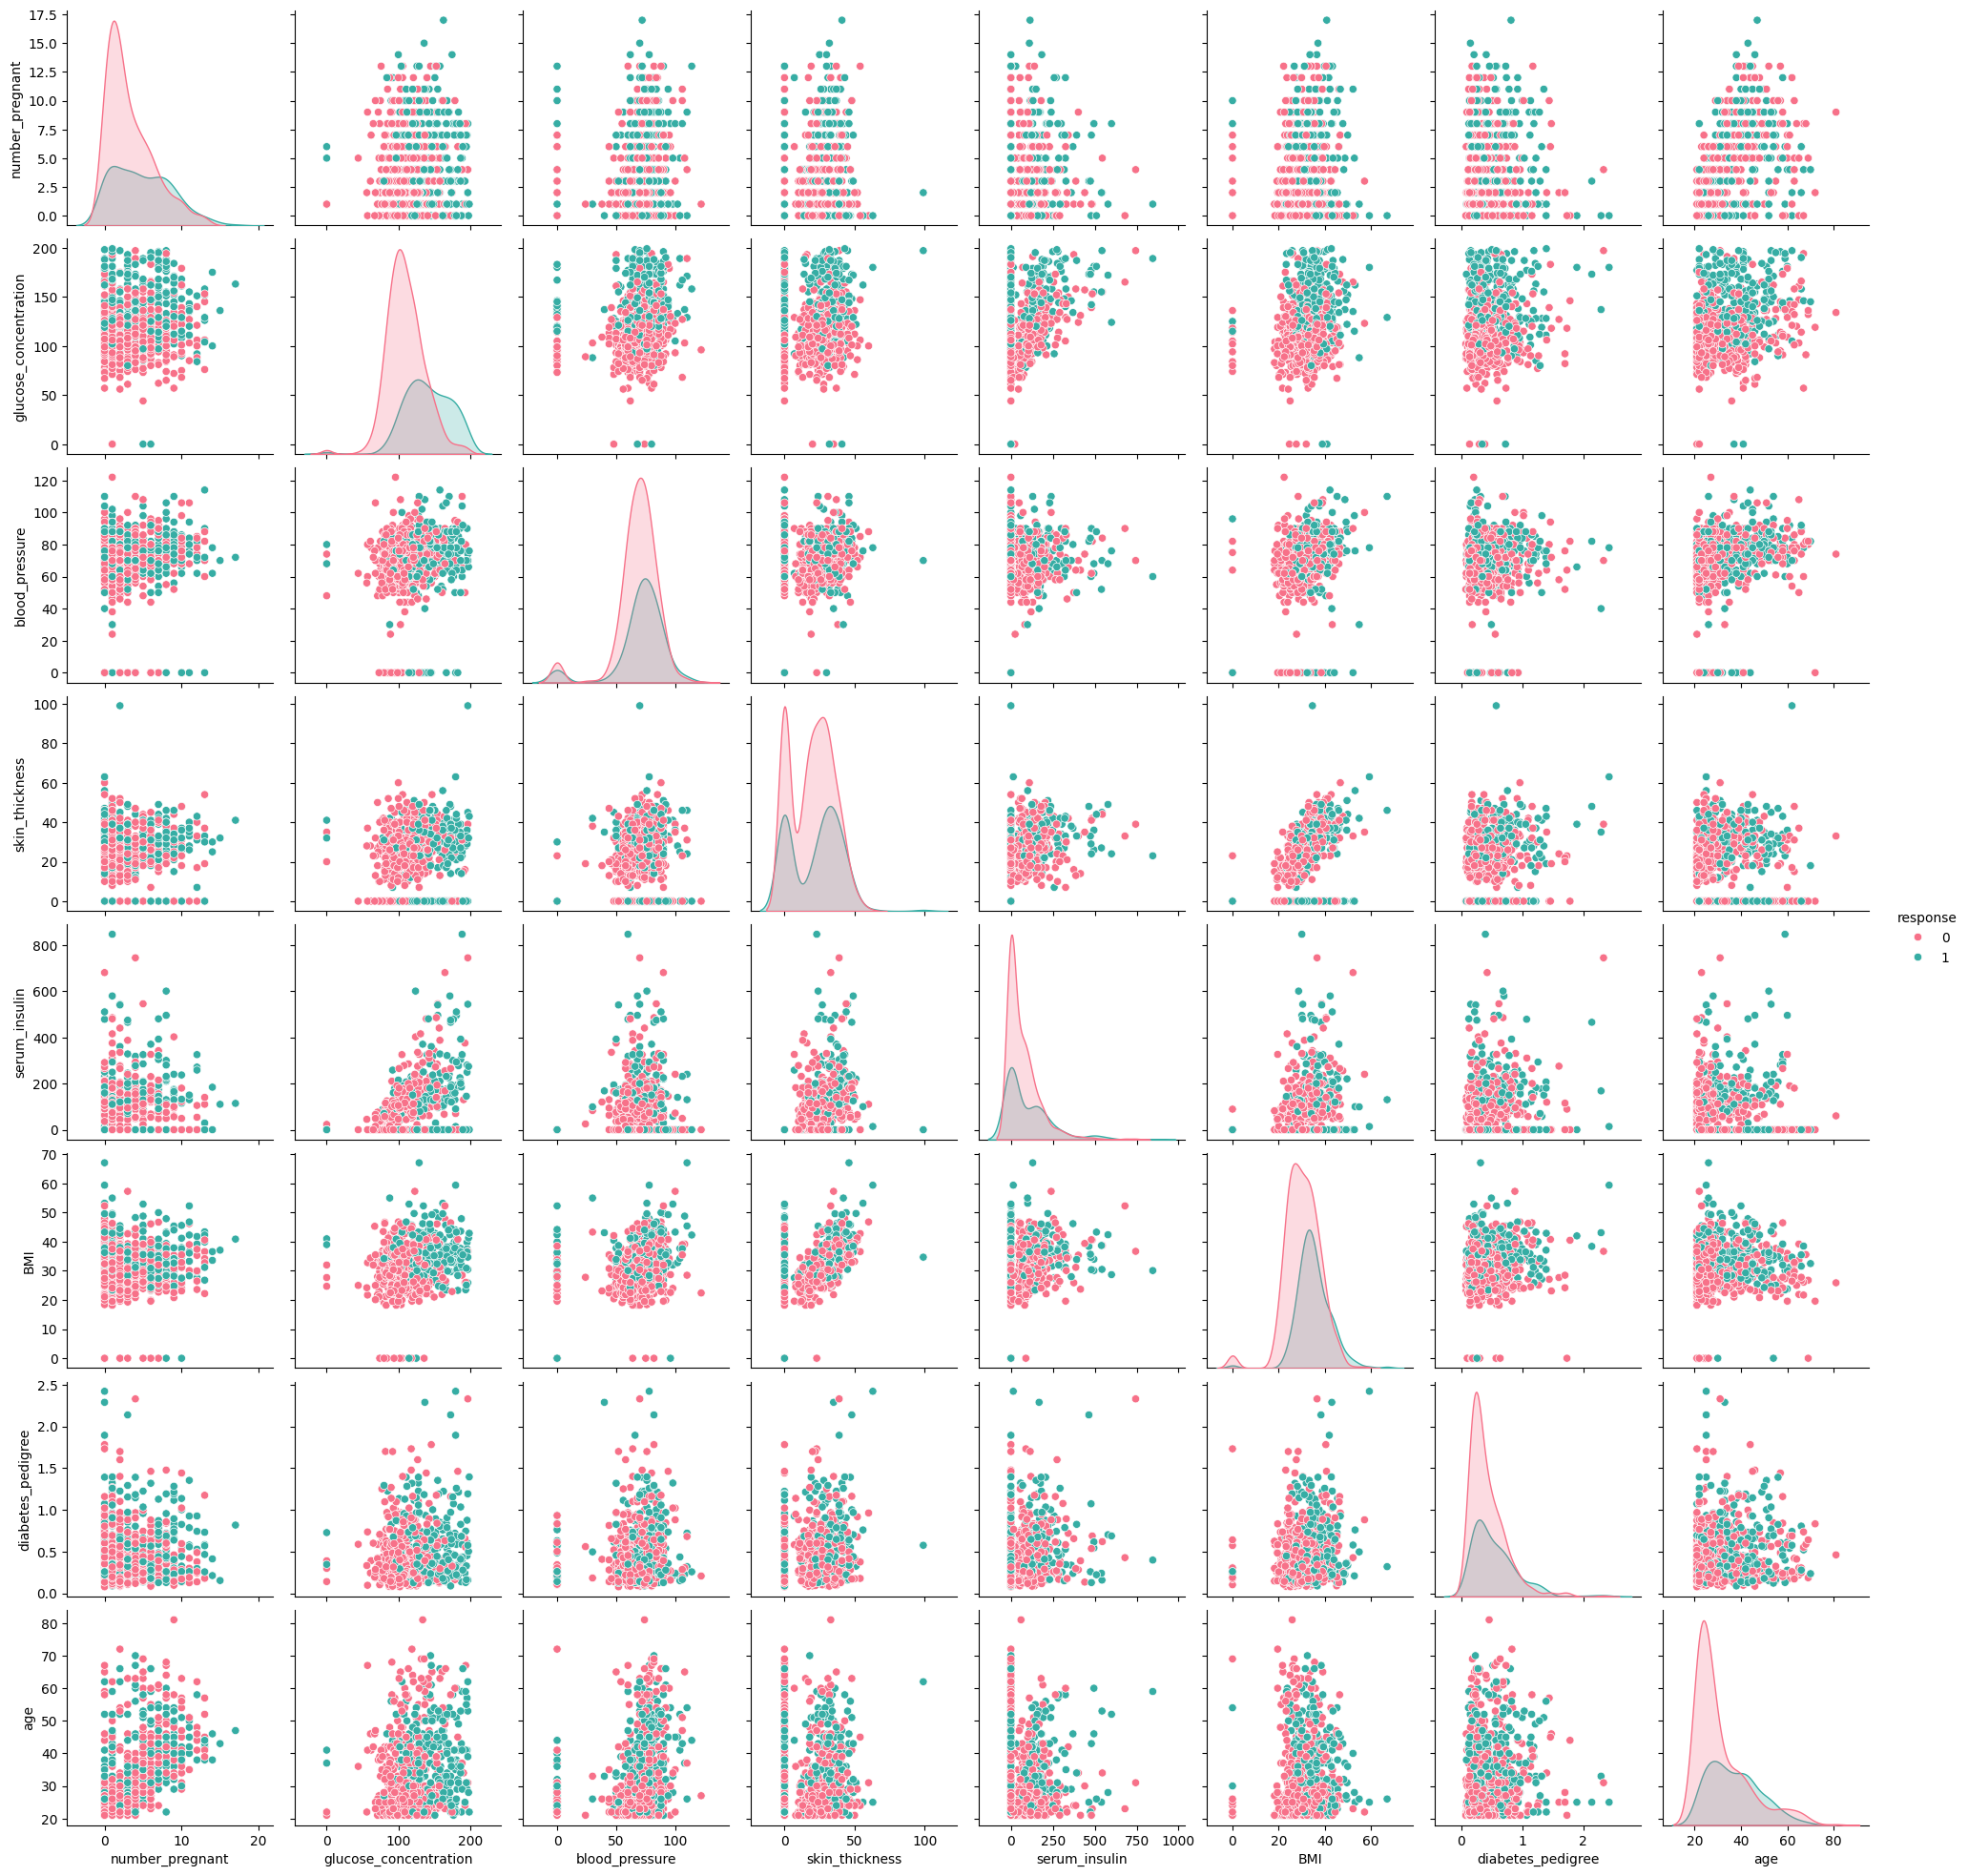

In [19]:
# THIS CELL IS NOT EXPORTED - free notebook cell for testing or development purposes
apply(model,df,param)

## Stage 5 - save the model

In [20]:
# save model to name in expected convention "<algo_name>_<model_name>"
def save(model,name):
    with open(MODEL_DIRECTORY + name + ".json", 'w') as file:
        json.dump(model, file)
    return model

In [21]:
model  = save(model,'correlationmatrix_diabetes_correlation')

## Stage 6 - load the model

In [22]:
# load model from name in expected convention "<algo_name>_<model_name>"
def load(name):
    model = {}
    with open(MODEL_DIRECTORY + name + ".json", 'r') as file:
        model = json.load(file)
    return model

In [23]:
model = load('correlationmatrix_diabetes_correlation')

## Stage 7 - provide a summary of the model

In [24]:
# return a model summary
def summary(model=None):
    returns = {"version": {"numpy": np.__version__, "pandas": pd.__version__} }
    return returns

## End of Stages
All subsequent cells are not tagged and can be used for further freeform code

In [25]:
summary(model)

{'version': {'numpy': '1.26.4', 'pandas': '2.2.0'}}